In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path=os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()

In [4]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

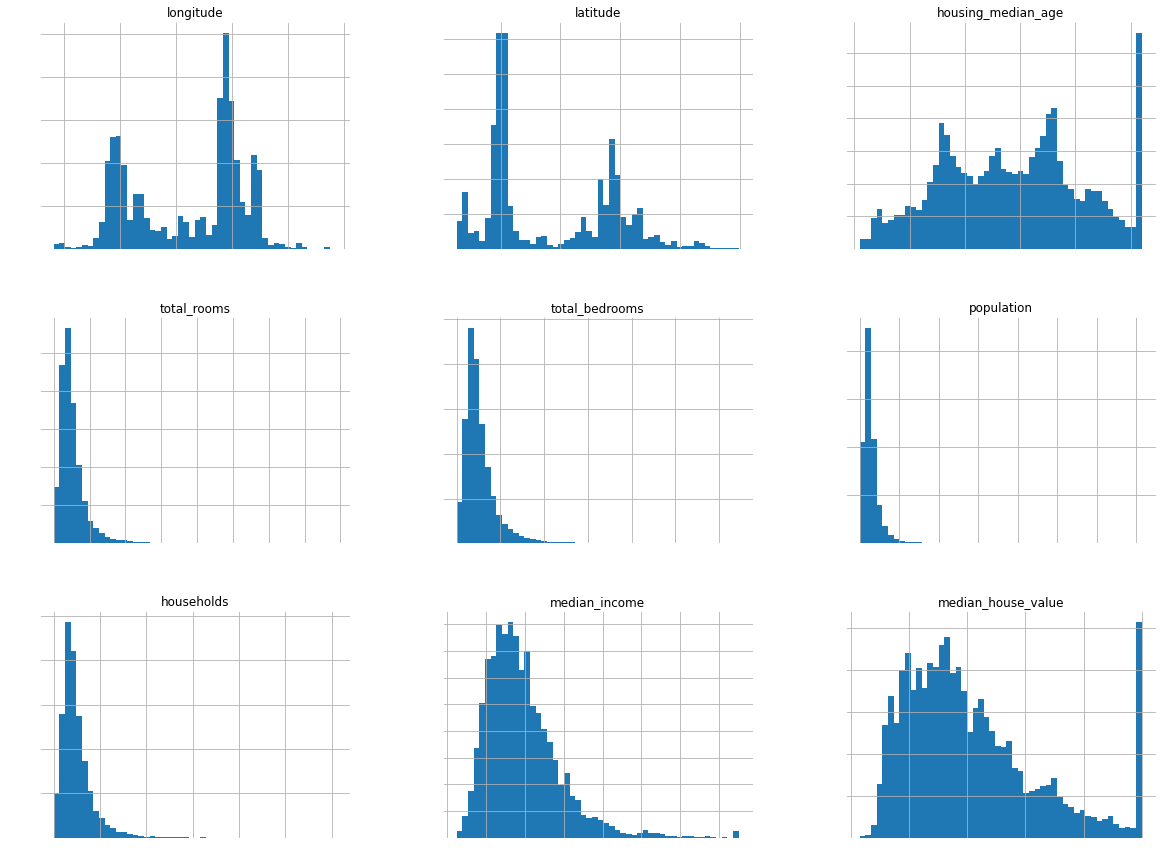

In [8]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
housing.hist(bins=50,figsize=(20,15))

In [9]:
def split_train_test(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_ndices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

def test_set_check(identifier,test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id=housing.reset_index()
train_set,test_set=split_train_test_by_id(housing_with_id,0.2,"index")

In [11]:
housing_with_id["id"]=housing["longitude"]*1000+housing["latitude"]
train_set,test_set=split_train_test_by_id(housing_with_id,0.2,"id")

In [12]:
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)

In [13]:
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],
                            labels=[1,2,3,4,5])

<AxesSubplot:>

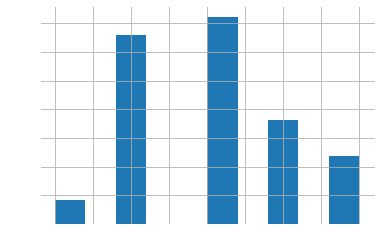

In [14]:
housing["income_cat"].hist()

In [15]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [18]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

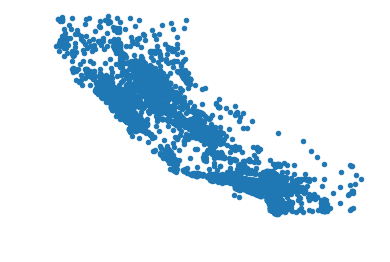

In [19]:
housing=strat_train_set.copy()
housing.plot(kind="scatter",x="longitude",y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

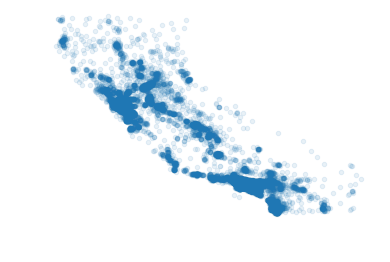

In [20]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

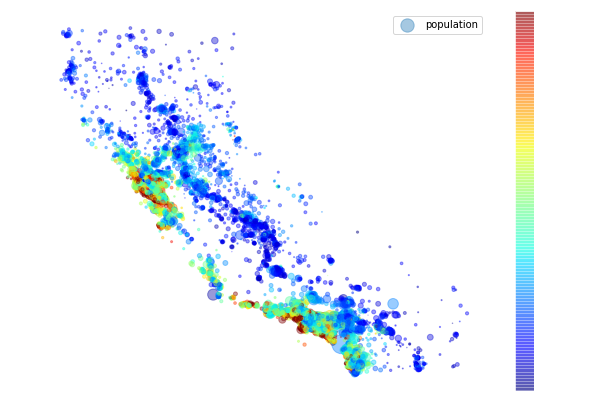

In [21]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
            s=housing["population"]/100,label="population",figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [22]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

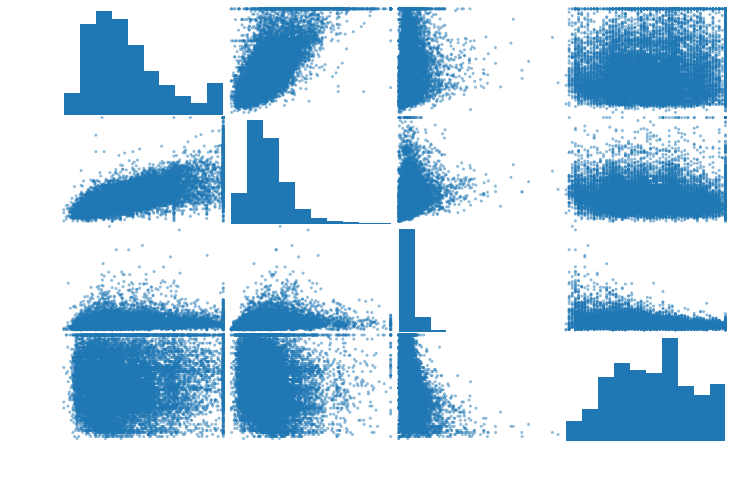

In [23]:
attributes=["median_house_value","median_income","total_rooms",
           "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

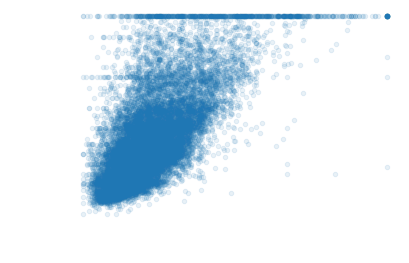

In [24]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [25]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [26]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [27]:
imputer=SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [28]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [29]:
cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [30]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [31]:
rooms_ix,bedrooms_ix,population_ix,households_ix=3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        rooms_per_household=X[:,rooms_ix]/X[:,households_ix]
        population_per_household=X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder=CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)

In [32]:
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ("attribs_adder",CombinedAttributesAdder()),
    ("std_scaler",StandardScaler())])

housing_num_tr=num_pipeline.fit_transform(housing_num)


In [33]:
num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]
full_pipeline=ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(),cat_attribs)
])

housing_prepared=full_pipeline.fit_transform(housing)

In [34]:
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)
print("Predictions: ",lin_reg.predict(some_data_prepared))
print("Labels: ",list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [35]:
housing_predictions=lin_reg.predict(housing_prepared)
lin_mse=mean_squared_error(housing_labels,housing_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [36]:
tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)
housing_predictions=tree_reg.predict(housing_prepared)
tree_mse=mean_squared_error(housing_labels,housing_predictions)
tree_rmse=np.sqrt(tree_mse)
tree_rmse

0.0

In [37]:
scores=cross_val_score(tree_reg,housing_prepared,housing_labels,
                      scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores=np.sqrt(-scores)
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Standard deviation: ",scores.std())
display_scores(tree_rmse_scores)

Scores:  [68997.78024142 65571.31899037 70997.11910219 70247.40061781
 71624.21088754 75984.54823347 71485.6023119  70087.6271966
 76346.09114099 69985.06065498]
Mean:  71132.67593772922
Standard deviation:  2996.4017249784997


In [38]:
scores=cross_val_score(lin_reg,housing_prepared,housing_labels,
                      scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores=np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.6740017983434


In [39]:
forest_reg=RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

scores=cross_val_score(forest_reg,housing_prepared,housing_labels,
                      scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores=np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores:  [49424.2018388  47990.72832923 49899.59362053 52338.35996053
 49695.85297276 53255.39309891 49220.07858019 48004.05872542
 52943.60967596 50219.8157702 ]
Mean:  50299.16925725428
Standard deviation:  1815.1310697307324


In [40]:
housing_predictions=forest_reg.predict(housing_prepared)
forest_mse=mean_squared_error(housing_labels,housing_predictions)
forest_rmse=np.sqrt(forest_mse)
forest_rmse

18696.123028943304

In [45]:
param_grid=[
    {"n_estimators": [3,10,30],"max_features": [2,4,6,8]},
    {"bootstrap":[False], "n_estimators":[3,10], "max_features": [2,3,4]}
]
forest_reg=RandomForestRegressor()
grid_search=GridSearchCV(forest_reg,param_grid,n_jobs=-1,cv=5,
                         scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(housing_prepared,housing_labels)
print("best params: {}".format(grid_search.best_params_))
print("best estimator: {}".format(grid_search.best_estimator_))

best params: {'max_features': 8, 'n_estimators': 30}
best estimator: RandomForestRegressor(max_features=8, n_estimators=30)


In [47]:
cvres=grid_search.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

63914.12942351792 {'max_features': 2, 'n_estimators': 3}
55626.98011006052 {'max_features': 2, 'n_estimators': 10}
52954.9224450381 {'max_features': 2, 'n_estimators': 30}
61277.40282983517 {'max_features': 4, 'n_estimators': 3}
52562.83422679442 {'max_features': 4, 'n_estimators': 10}
50322.613376849964 {'max_features': 4, 'n_estimators': 30}
58892.2254977651 {'max_features': 6, 'n_estimators': 3}
52287.592243697625 {'max_features': 6, 'n_estimators': 10}
50108.7488289614 {'max_features': 6, 'n_estimators': 30}
58607.96620296848 {'max_features': 8, 'n_estimators': 3}
52671.133393938515 {'max_features': 8, 'n_estimators': 10}
49950.86882526428 {'max_features': 8, 'n_estimators': 30}
62429.57979685816 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54384.559917458 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60389.02117695733 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52548.673838823335 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

C:\Users\Daniel\anaconda3\envs\py37ml\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

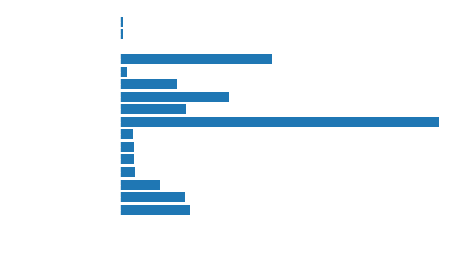

In [64]:

extra_attribs=["rooms_perh_hold","pop_per_hhold","bedrooms_per_room"]
cat_encoder=full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs=list(cat_encoder.categories_[0])
attributes=num_attribs+extra_attribs+cat_one_hot_attribs
plt.barh(attributes,feature_importances,align="center")
plt.xticks(rotation=90)

array(['0.0742101921966202', '0.06907391034991407', '0.0420191630073884',
       '0.01558798497572667', '0.01432456863479558',
       '0.015250220670618743', '0.013620354511891383',
       '0.3370606580788527', '0.06963122082632309', '0.11481758569318405',
       '0.05997890544997727', '0.007204083752146391',
       '0.16037272837173655', '2.962901971764931e-05',
       '0.0037377374277172237', '0.0030810570333899842'], dtype='<U32')

In [67]:
final_model=grid_search.best_estimator_
X_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set["median_house_value"].copy()

X_test_prepared=full_pipeline.transform(X_test)
final_predictions=final_model.predict(X_test_prepared)

final_mse=mean_squared_error(y_test,final_predictions)
final_rmse=np.sqrt(final_mse)
final_rmse

47371.95646851778

In [69]:
from scipy import stats
confidence=0.95
squared_errors=(final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45387.96043865, 49276.13587254])